Please, do NOT commit changes in this notebook without deleting the output first. There are some high-resolution plots for which we can't afford to store every version in the Git repository.

# Initialize and run the simulation

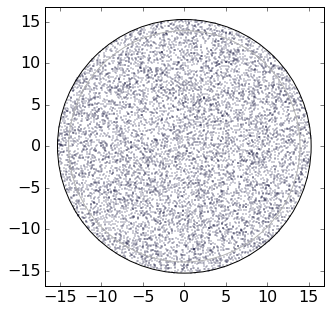

In [8]:
%run "initialize_posrectest.ipynb"

In [9]:
# n_pe is the total number of pe OBSERVED in the S2 (top and bottom arrays)
n_pe = 1300
n_trials = int(4e4)

%run "run_posrectest.ipynb"

# Plot the results

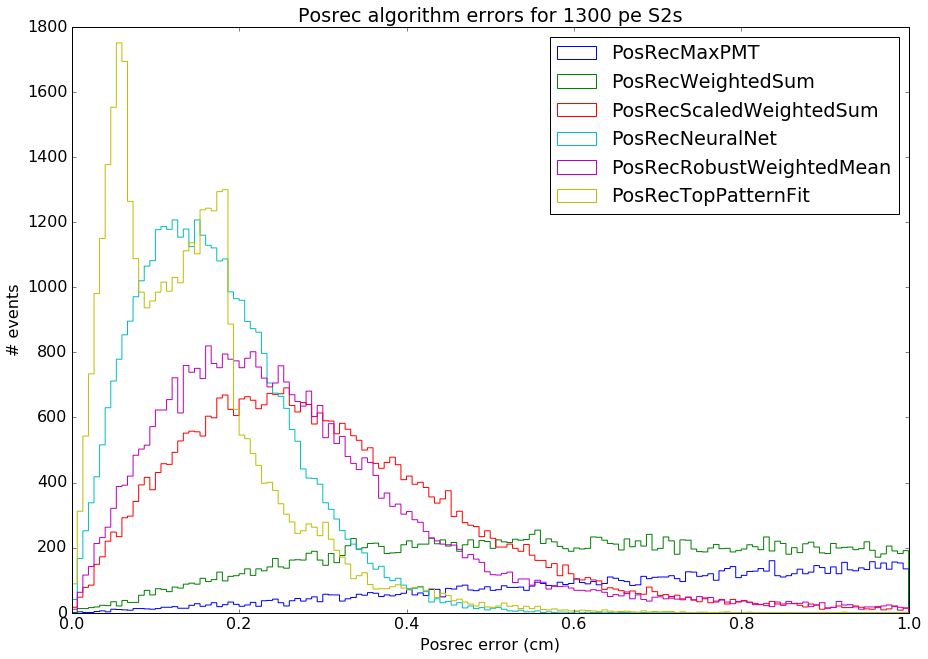

In [10]:
##
# Error histogram plot
##
plt.figure(figsize=(10*size_multiplier, 7*size_multiplier))
for pp in posrec_plugins:
    plt.hist(differences[pp.name], bins=150, range=(0, 1), histtype='step', label=pp.name)
plt.legend(loc='upper right')
plt.xlabel('Posrec error (cm)')
plt.ylabel('# events')
title = 'Posrec algorithm errors for %d pe S2s' % n_pe
plt.title(title)
save_plot(title)
plt.show()

In [11]:
# Show the mean bias for each algorithm
for pp in posrec_plugins:
    print("Mean bias vector for %s: %s cm" % (pp.name, (rps[pp.name] - np.vstack((xs, ys)).T).mean(axis=0)))

Mean bias vector for PosRecMaxPMT: [-0.00292624 -0.00267538] cm
Mean bias vector for PosRecWeightedSum: [-0.02665145 -0.09495142] cm
Mean bias vector for PosRecScaledWeightedSum: [-0.02678252 -0.09923722] cm
Mean bias vector for PosRecNeuralNet: [-0.00114622  0.00277097] cm
Mean bias vector for PosRecRobustWeightedMean: [-0.01532969 -0.03810825] cm
Mean bias vector for PosRecTopPatternFit: [ 0.00032482  0.00041529] cm


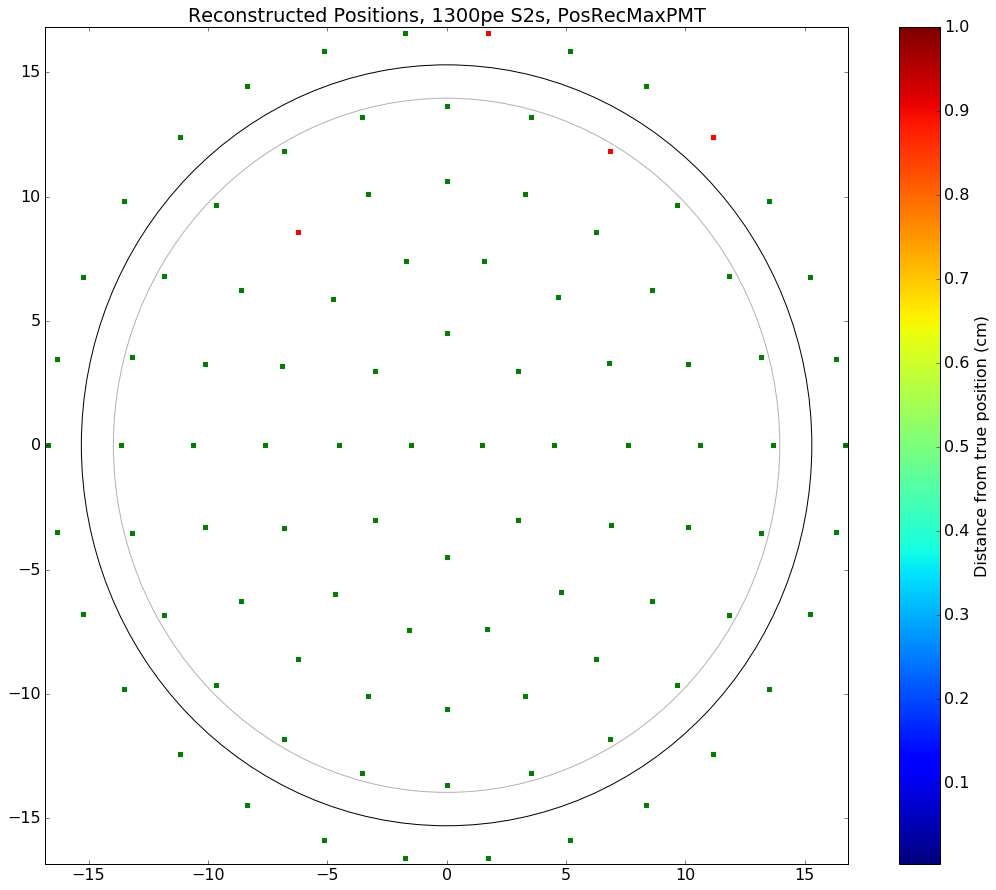

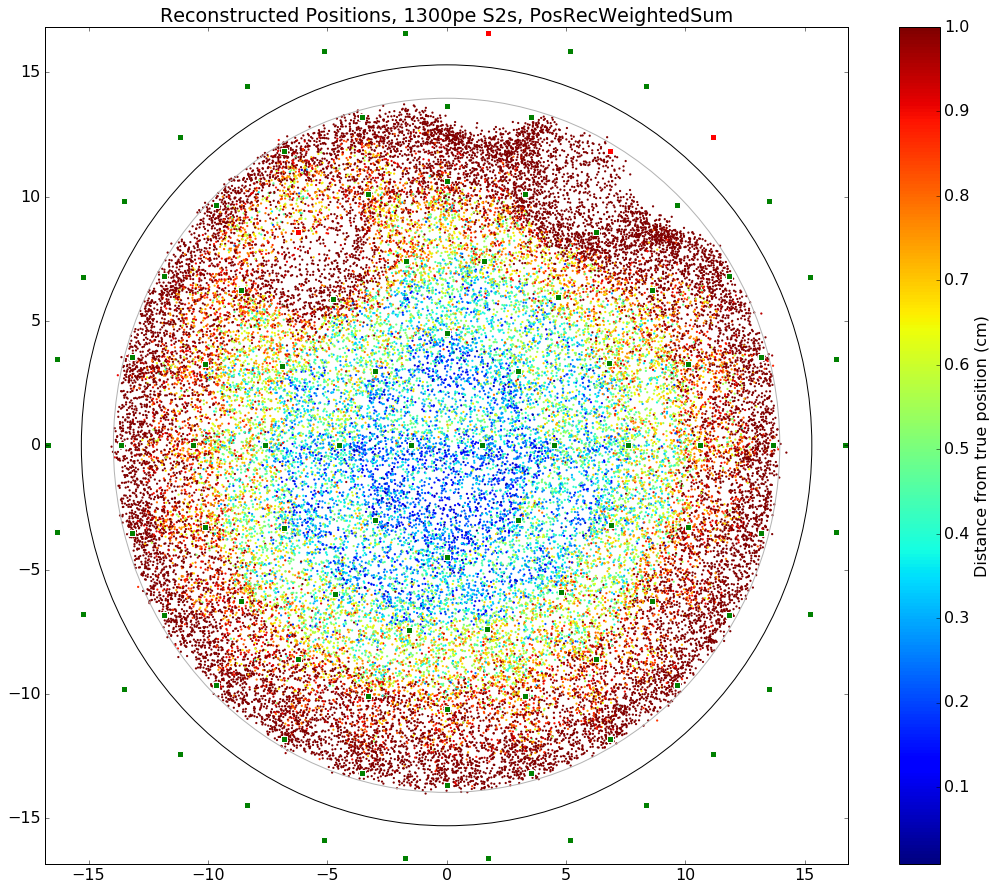

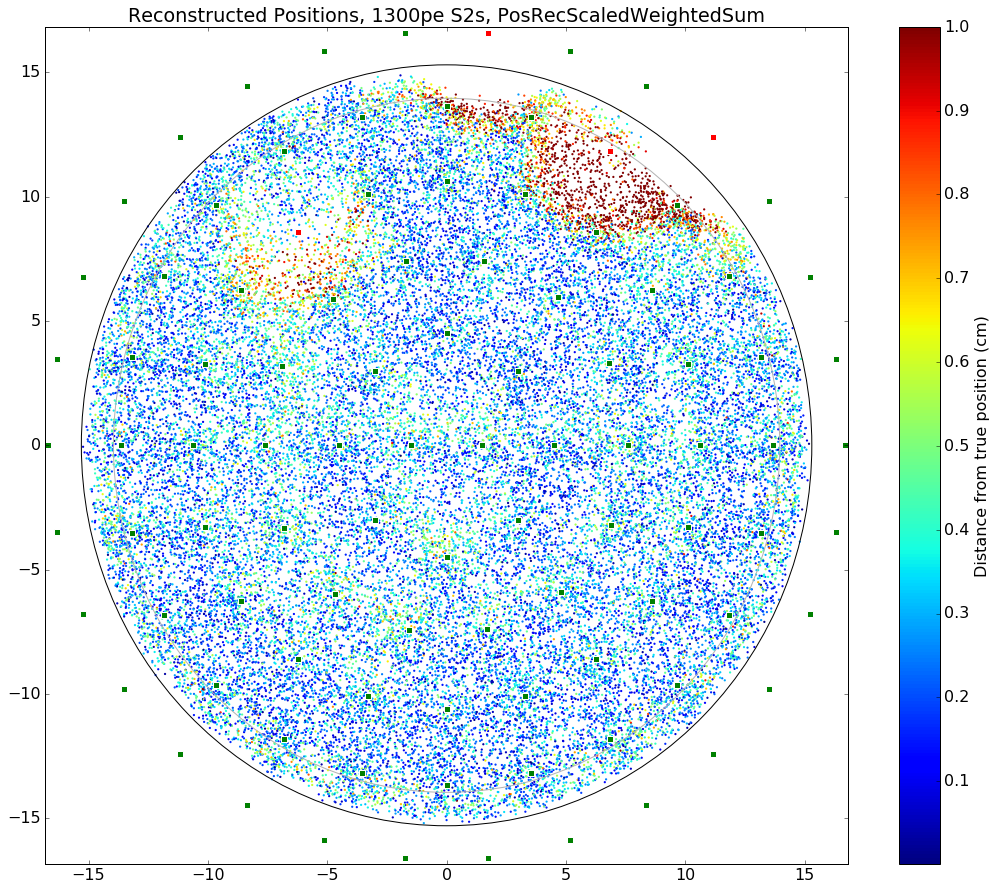

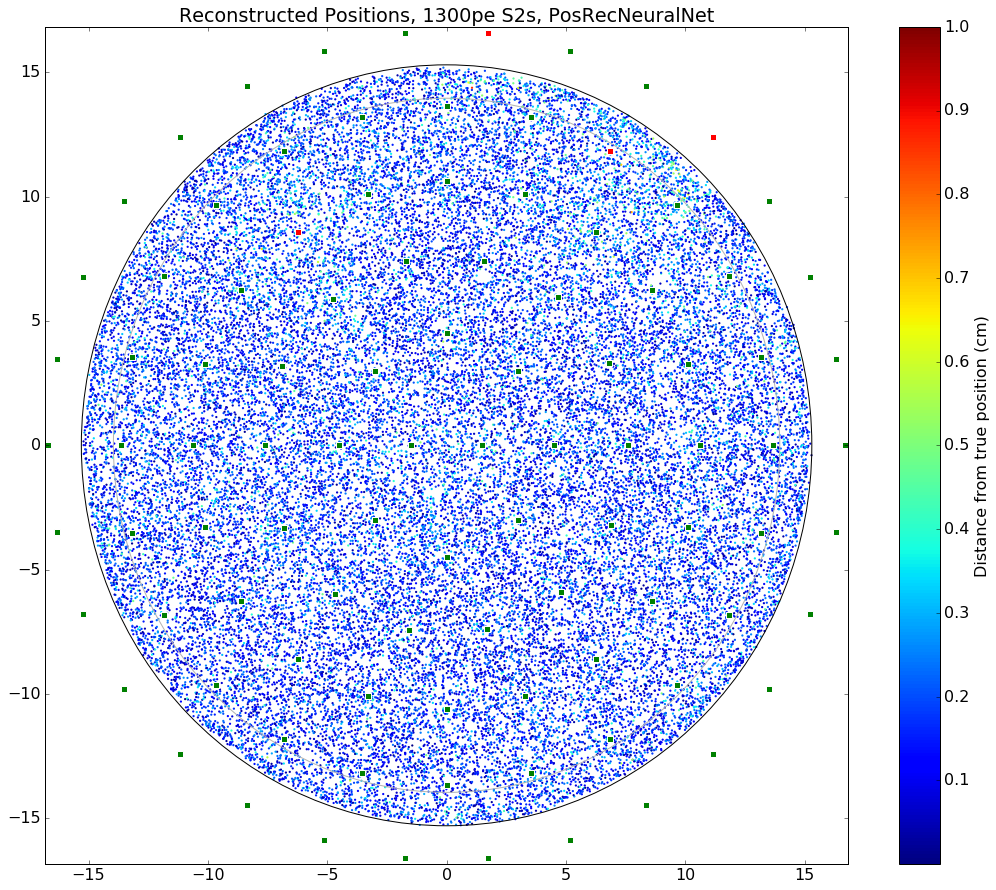

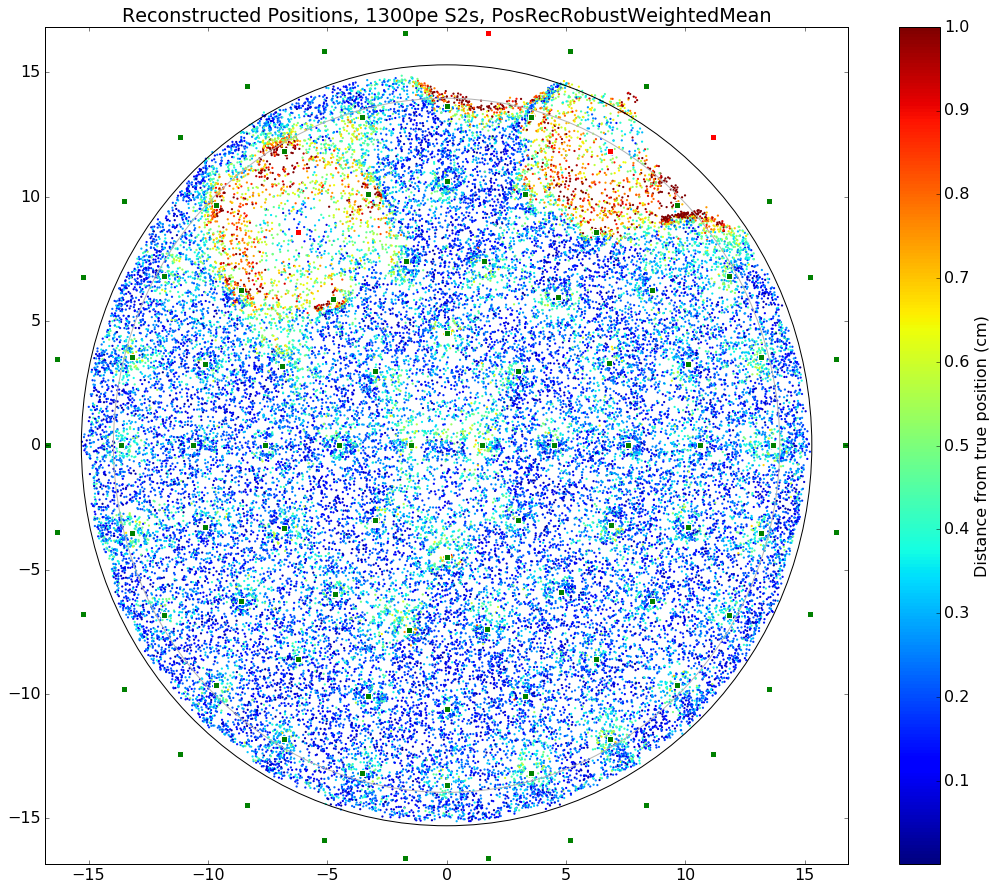

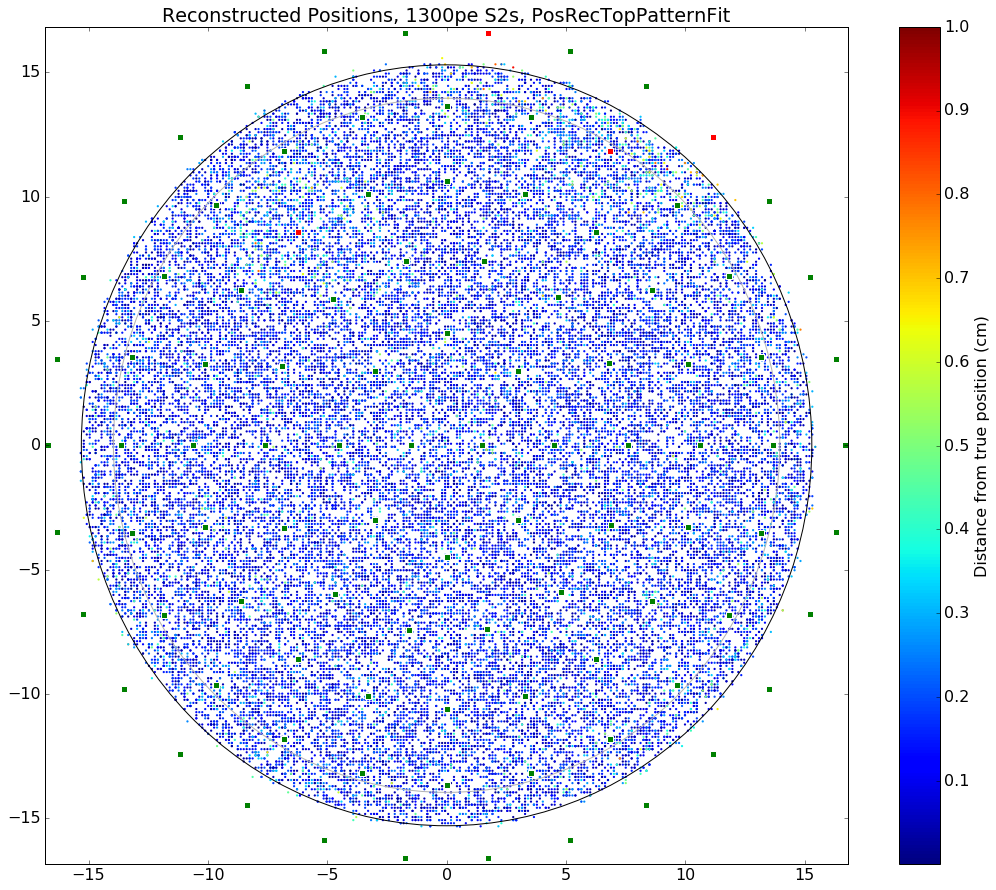

In [12]:
##
# Scatter plot of reconstructed positions
##
for pp in posrec_plugins:
    plt.figure(figsize=(12*size_multiplier,10*size_multiplier))
    plt.scatter(rps[pp.name][:,0], rps[pp.name][:,1],
                c=differences[pp.name], marker='.', edgecolors='none', vmax=1)
    plt.colorbar(label='Distance from true position (cm)')
    plot_detector_radius()
    plot_top_array()
    title = 'Reconstructed Positions, %dpe S2s, %s' % (n_pe, pp.name)
    plt.title(title)
    save_plot(title)
    plt.show()

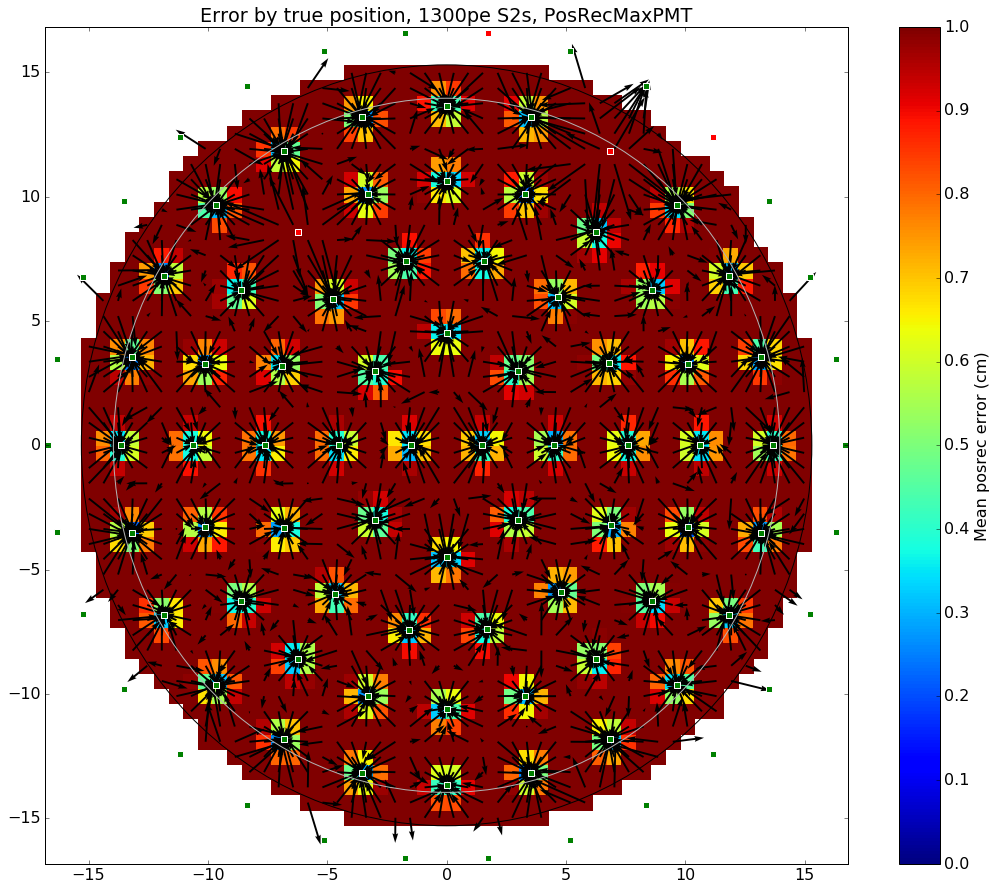

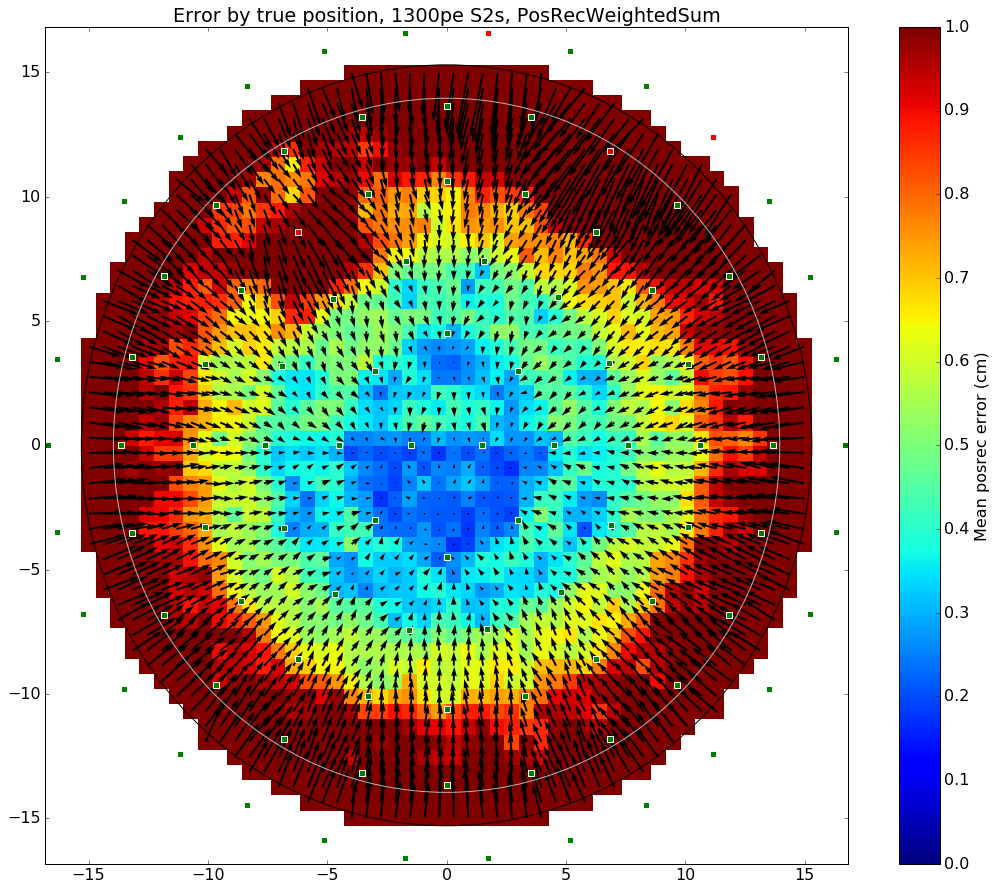

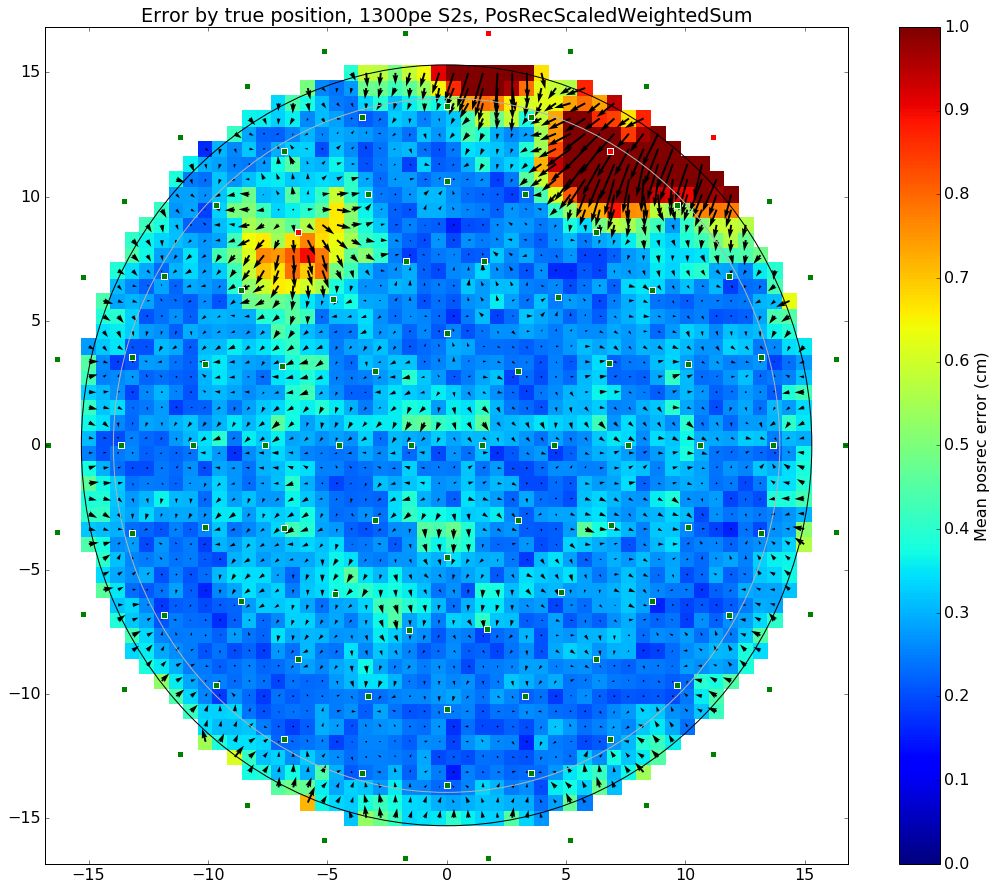

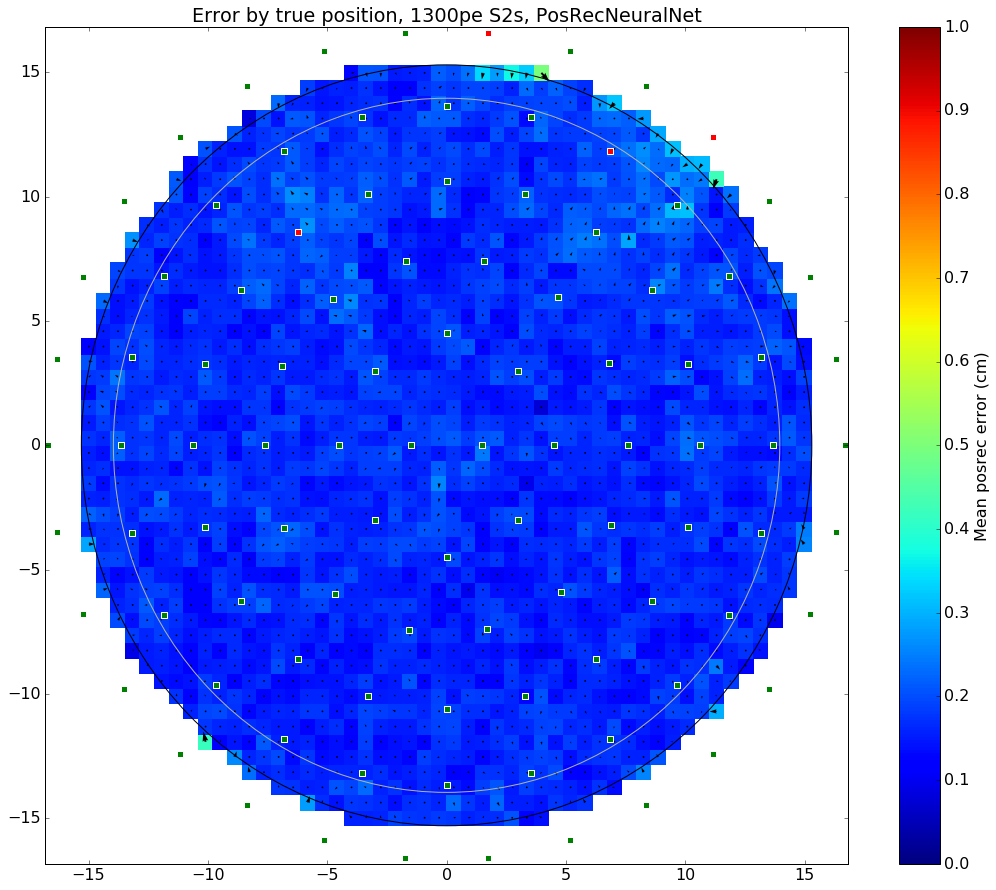

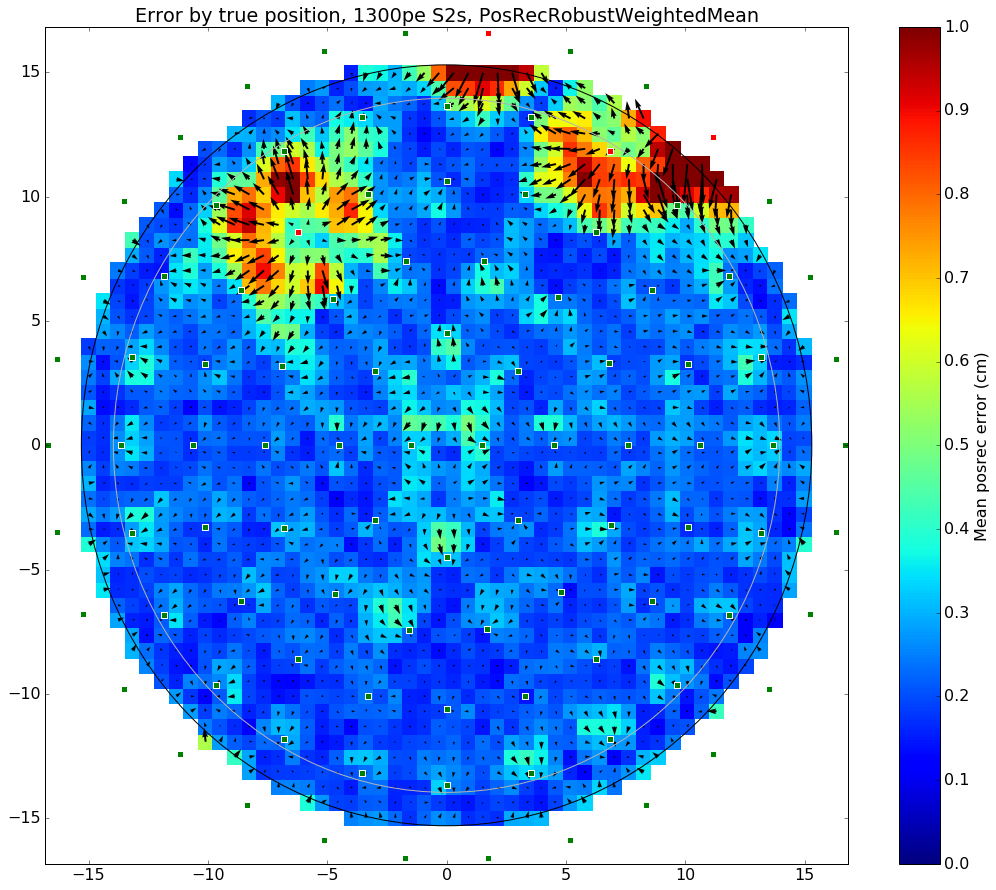

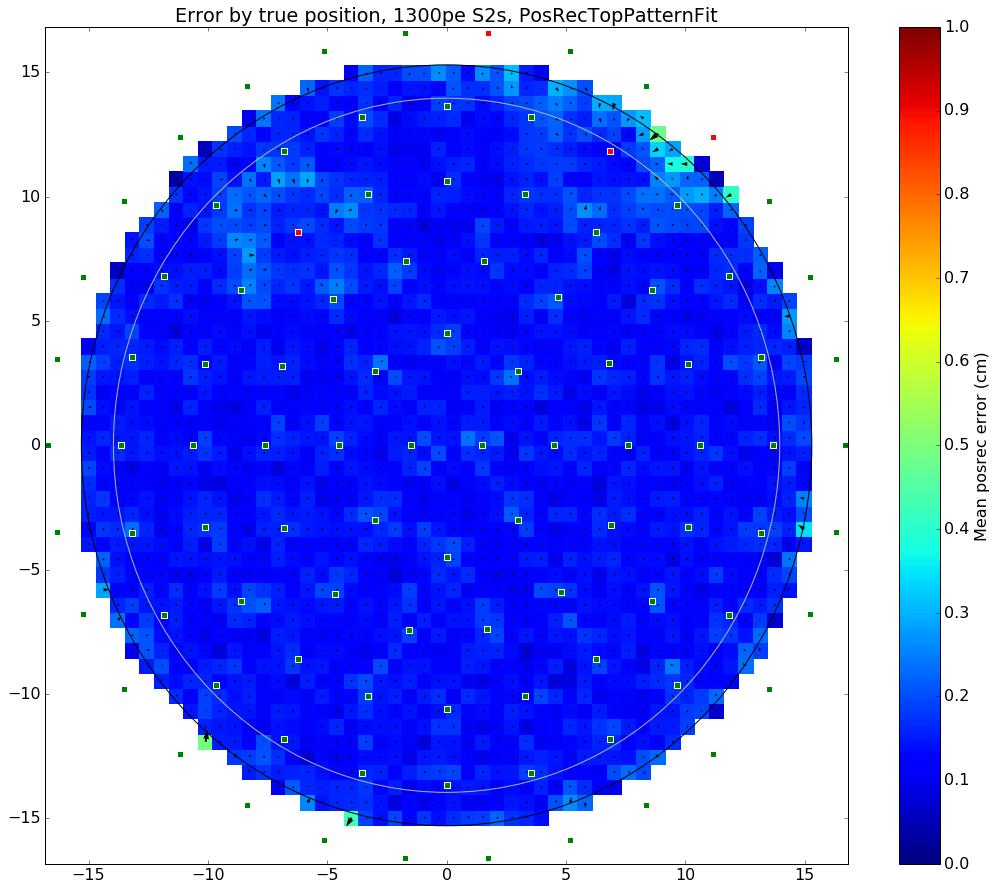

In [13]:
##
# Spatial error and bias plot
##

def twod_stat_plot(x, y, z, statistic='mean', bins=10, range=None, vrange=None, cblabel=None):
    if vrange is None:
        vrange = (None, None)
    result, xbinedges, ybinedges, binnumbers = binned_statistic_2d(
        x, y, z,
        bins=bins,
        statistic=statistic,
        range=range
    )
    xx, yy = np.meshgrid(xbinedges, ybinedges)    

    Zm = np.ma.masked_where(np.isnan(result),result)
    plt.figure(figsize=(size_multiplier*12, size_multiplier*10))
    plt.pcolormesh(xx, yy, Zm, vmin=vrange[0], vmax=vrange[1])
    plt.colorbar(label=cblabel)

for pp in posrec_plugins:
    pp_name = pp.name
    bins = 50

    twod_stat_plot(ys, xs, differences[pp_name],
                   bins=bins, vrange=(0, 1),                   
                   cblabel='Mean posrec error (cm)')
    
    twod_difs = rps[pp_name] - np.array([xs, ys]).T

    x_bias, _, _, _ = binned_statistic_2d(
        xs, ys, twod_difs[:,0],
        bins=bins,
        statistic='mean',
    )
    y_bias, xbinedges, ybinedges, binnumbers = binned_statistic_2d(
        xs, ys, twod_difs[:,1],
        bins=bins,
        statistic='mean',
    )
    
    xx_center, yy_center = np.meshgrid(bin_centers(xbinedges), bin_centers(ybinedges))    
    xx, yy = np.meshgrid(xbinedges, ybinedges)    
    
    plt.quiver(yy_center, xx_center, x_bias, y_bias, 
               angles='xy', scale_units='xy', scale=1, pivot='tail')
    
    plot_top_array()
    plot_detector_radius() 
    title = 'Error by true position, %dpe S2s, %s' % (n_pe, pp_name)
    plt.title(title)
    save_plot(title)

In [14]:
for pp in posrec_plugins:
    pp_name = pp.name
    print(pp,pp.name)

<MaxPMT.PosRecMaxPMT object at 0x7fb77b3dc0f0> PosRecMaxPMT
<WeightedSum.PosRecWeightedSum object at 0x7fb77b50edd8> PosRecWeightedSum
<WeightedSum.PosRecScaledWeightedSum object at 0x7fb7698a1ac8> PosRecScaledWeightedSum
<NeuralNet.PosRecNeuralNet object at 0x7fb7698a1f28> PosRecNeuralNet
<RobustWeightedMean.PosRecRobustWeightedMean object at 0x7fb77b50ea20> PosRecRobustWeightedMean
<TopPatternFit.PosRecTopPatternFit object at 0x7fb78799ae80> PosRecTopPatternFit


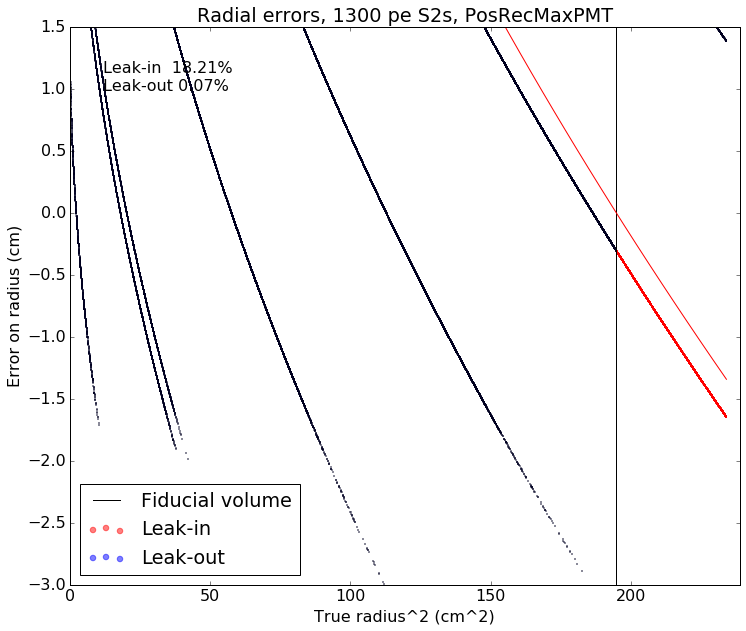

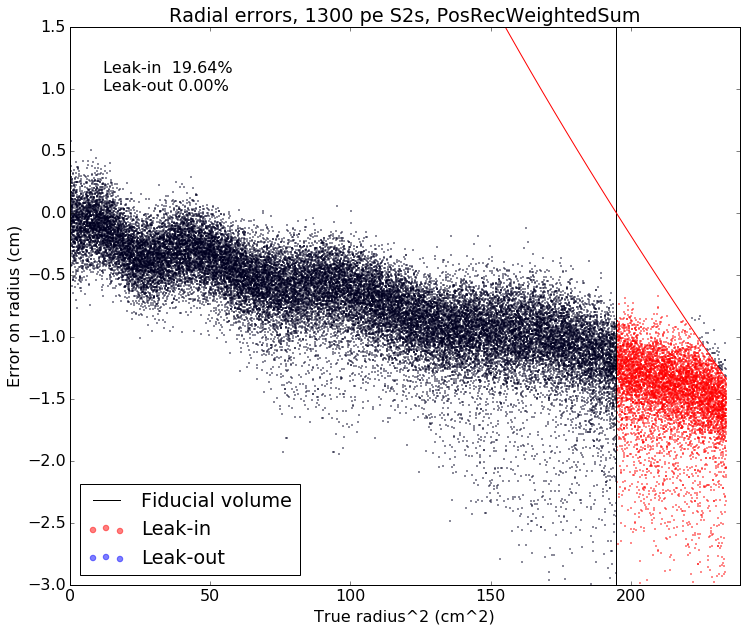

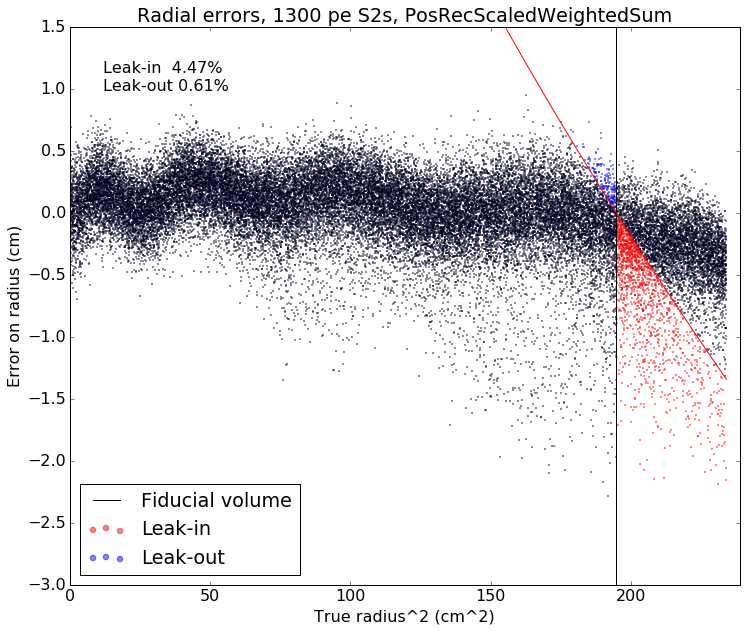

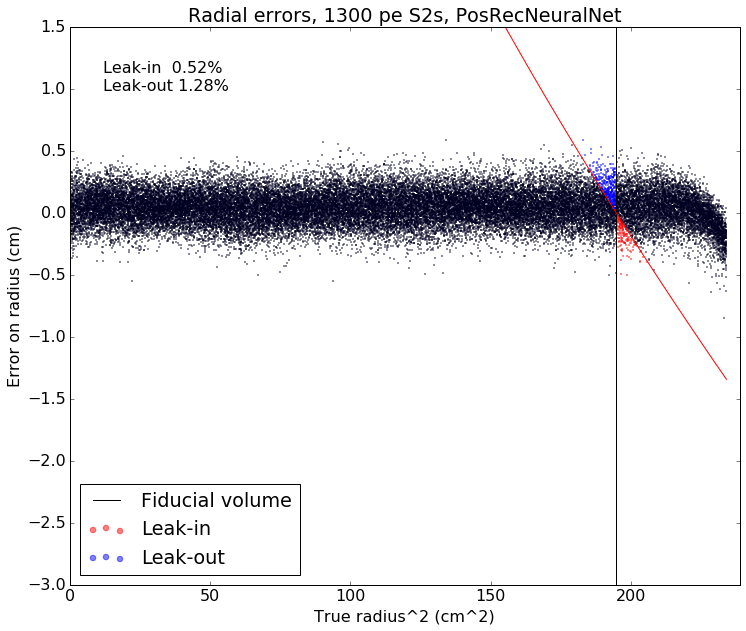

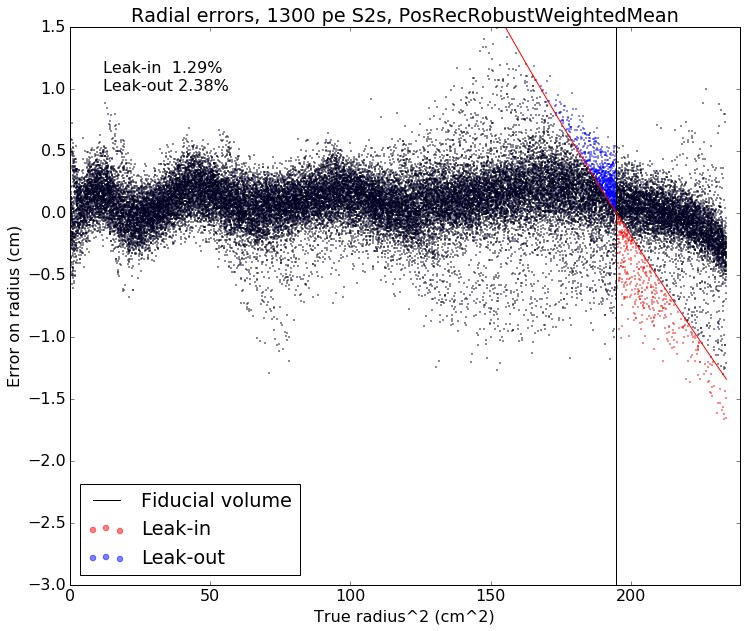

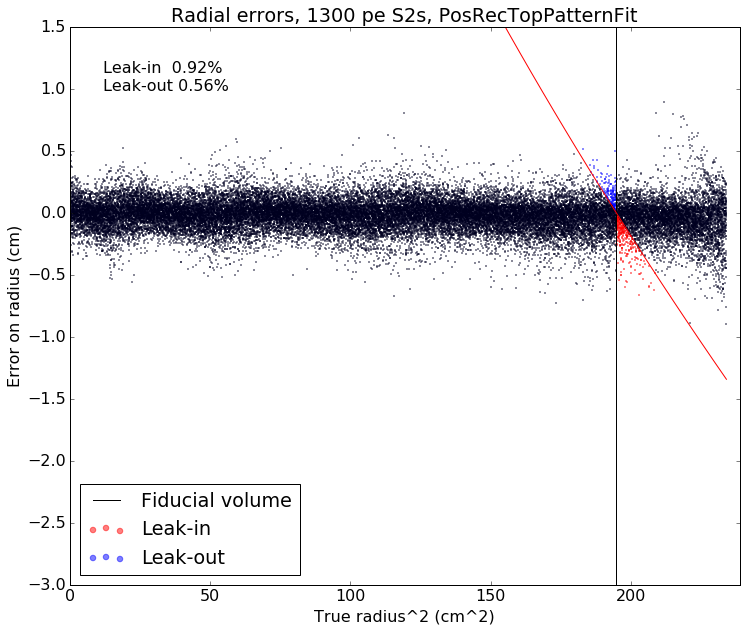

In [15]:
##
# Radial errors scatter plot
##
for pp in posrec_plugins:
    pp_name = pp.name
    
    rs = np.sqrt(np.array(xs)**2+np.array(ys)**2)
    rs_rec = np.sqrt(rps[pp_name][:,0]**2 + rps[pp_name][:,1]**2)
    radial_errors = rs_rec - rs
    
    plt.figure(figsize=(12, 10))
    
    leak_in =  (rs > fiducial_volume_radius) & (rs_rec < fiducial_volume_radius)
    leak_out = (rs < fiducial_volume_radius) & (rs_rec > fiducial_volume_radius)
    
    plt.scatter(rs[leak_in]**2, 
                radial_errors[leak_in], 
                s=1, alpha=0.5, label='Leak-in', color='red')
    
    plt.scatter(rs[leak_out]**2, 
                radial_errors[leak_out], 
                s=1, alpha=0.5, label='Leak-out', color='blue')
    
    plt.scatter(rs[True ^ (leak_out | leak_in)]**2, 
                radial_errors[True ^ (leak_out | leak_in)], 
                s=1, alpha=0.5)
    
    message = "Leak-in  %0.2f%%\nLeak-out %0.2f%%" % (
            100 * len(np.where(leak_in)[0])/len(np.where(rs < fiducial_volume_radius)[0]),
            100 * len(np.where(leak_out)[0])/len(np.where(rs < fiducial_volume_radius)[0]))
    plt.text(0.05, 0.91, message,
         horizontalalignment='left',
         verticalalignment='center',
         transform = plt.gca().transAxes)
                                                    
    plt.axvline(fiducial_volume_radius**2, color='black', 
                label='Fiducial volume')

    rarg = np.linspace(0, detector_radius, 100)
    error_for_fv = fiducial_volume_radius - rarg    
    plt.plot(rarg**2, error_for_fv, color='red')
    
    plt.xlim(0, 1.02*detector_radius**2)
    plt.ylim(-3, 1.5)
    plt.xlabel('True radius^2 (cm^2)')
    plt.ylabel('Error on radius (cm)')
    leg = plt.legend(loc='lower left')
    for l in leg.legendHandles:
        l._sizes = [30]
    title = 'Radial errors, %d pe S2s, %s' % (n_pe, pp_name)
    plt.title(title)
    save_plot(title)
    plt.show()

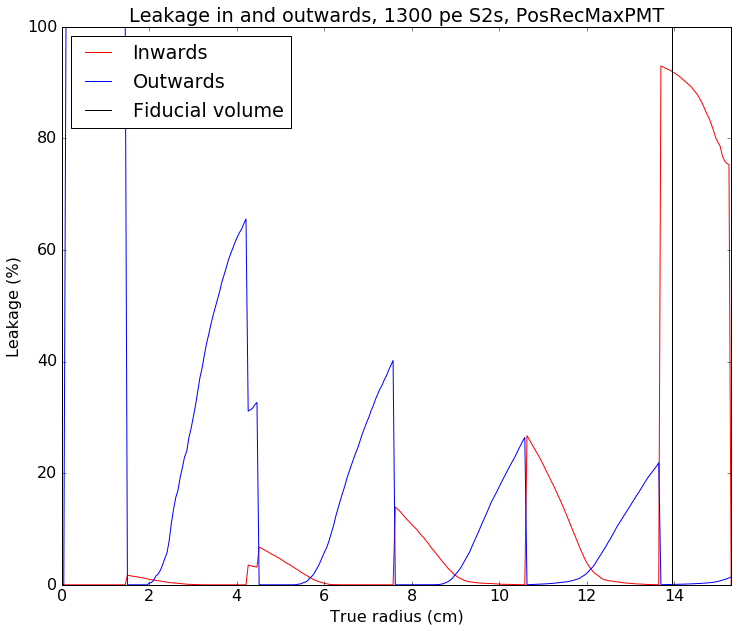

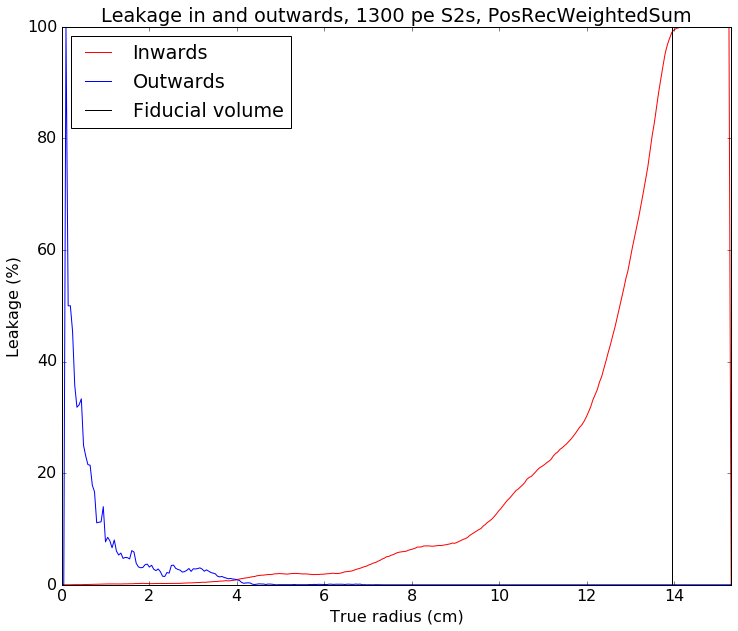

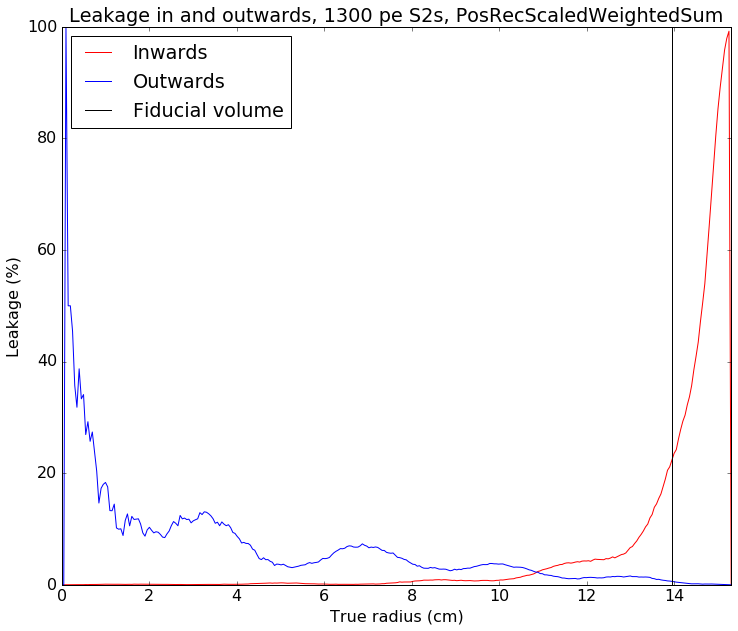

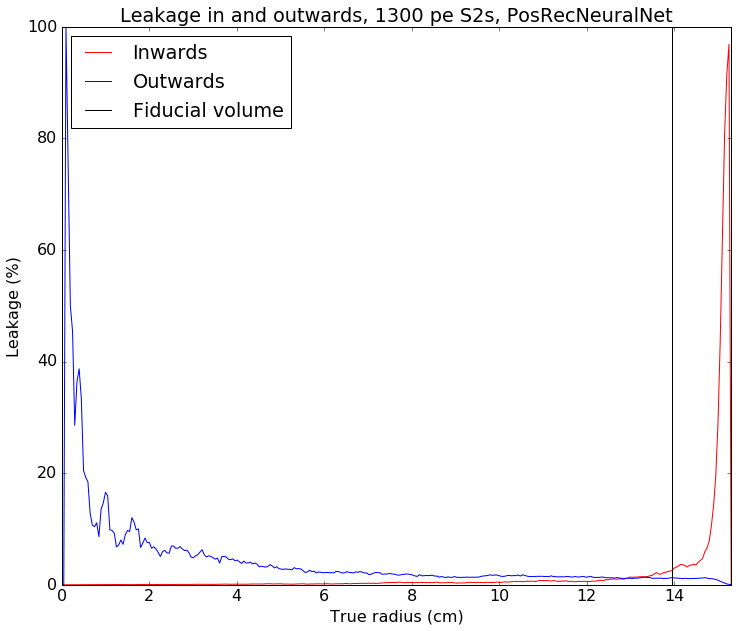

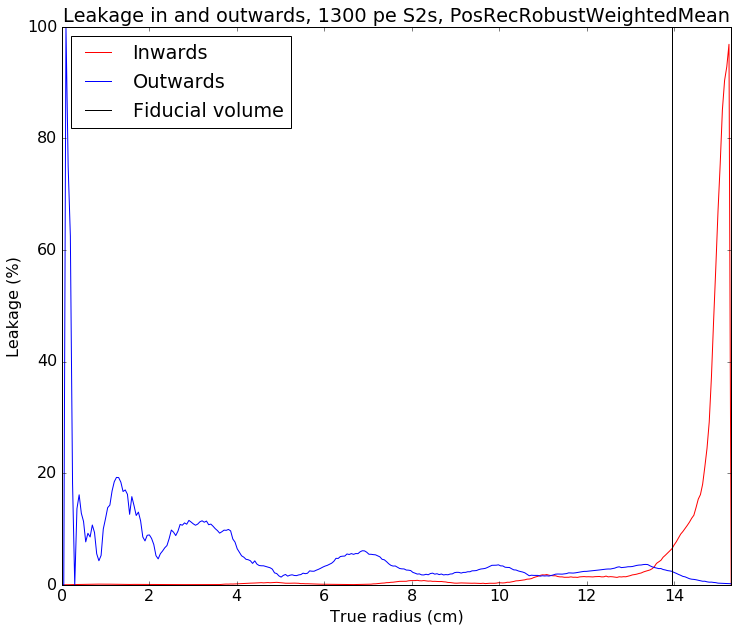

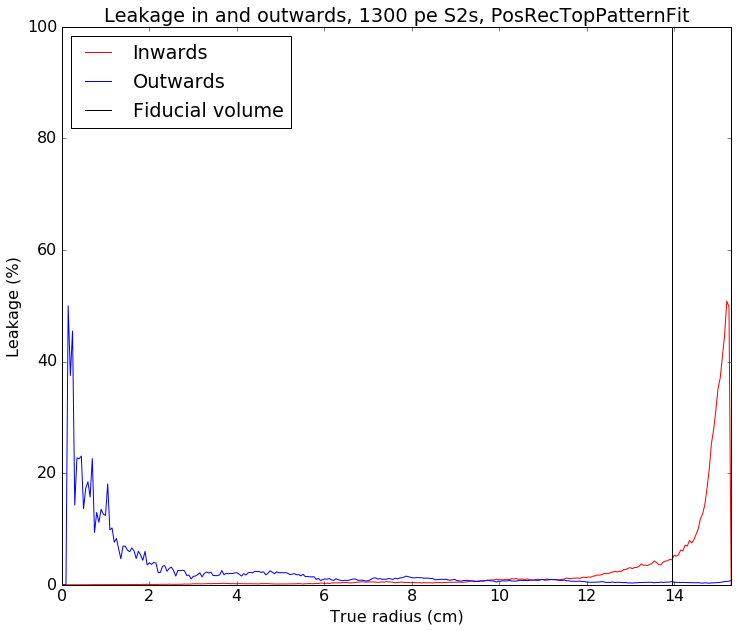

In [16]:
##
# Leakage plot
##

def leakage_percentages(rs, rs_rec, r):
    """
    rs: true radial positions
    rs_rec: reconstructed radial positions
    r: radius/radii to test ro test
    returns 2-tuple /array of 2-tuples with (leak_in, leak_out) info:    
        leak_in  = % events outside the radius, that are reconstructed inside
        leak_out = % of events inside the radius, that are reconstructed outside
    """
    # Allow calling with one radius or several radii
    try:
        r[0]
    except TypeError:
        r = [r]
    leakage_in = []
    leakage_out = []
    for radius in r:
        n_outside = np.count_nonzero(rs > radius)
        n_inside = np.count_nonzero(rs < radius)
        n_leak_in =  np.count_nonzero((rs > radius) & (rs_rec < radius))
        n_leak_out = np.count_nonzero((rs < radius) & (rs_rec > radius))
        leakage_in.append(100 * n_leak_in/n_outside if n_outside > 0 else 0)
        leakage_out.append(100 * n_leak_out/n_inside if n_inside > 0 else 0)
    return leakage_in, leakage_out

for pp in posrec_plugins:
    pp_name = pp.name
    
    rs = np.sqrt(np.array(xs)**2+np.array(ys)**2)
    rs_rec = np.sqrt(rps[pp_name][:,0]**2 + rps[pp_name][:,1]**2)
    radial_errors = rs_rec - rs
    
    plt.figure(figsize=(12, 10))
    
    r = np.linspace(0, detector_radius, int(detector_radius/(0.5 * units.mm)))
    inwards, outwards = leakage_percentages(rs,rs_rec,r)
    plt.plot(r, inwards, label = 'Inwards', color='red')
    plt.plot(r, outwards, label = 'Outwards', color='blue')
    
    plt.axvline(fiducial_volume_radius, color='black', 
            label='Fiducial volume')

    plt.xlabel('True radius (cm)')
    plt.ylabel('Leakage (%)')
    plt.ylim(0,100)
    plt.xlim(0,detector_radius)
    leg = plt.legend(loc='upper left')
    for l in leg.legendHandles:
        l._sizes = [30]
    title = 'Leakage in and outwards, %d pe S2s, %s' % (n_pe, pp_name)
    plt.title(title)
    save_plot(title)
    plt.show()

In [17]:
## Save simulated data
# np.savez_compressed("%s_posrectest_data_%dpe_%dtrials" % (strftime("%Y%m%d"), n_pe, n_trials),
#                     xs=xs,
#                     ys=ys,
#                     rps=rps,
#                     differences=differences)

In [18]:
## Load previously simulated data
# data = np.load('20150801_posrectest_data_1000pe_1000trials.npz')
# xs = data['xs']
# ys = data['ys']
# rps = data['rps'].item()
# differences = data['differences'].item()
# data.close()